# Text preprocessing and representation in NLP

In [42]:
import numpy as np
import pandas as pd
import pickle

from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec

import functions as f

## Text preprocessing

The goal of this part is to transform product reviews into lists of tokens. Since the dataset consists of over 1.4M reviews, for the purpose of this project it will be limited to 100k (to fasten computations).

Text preprocessing includes:
- converting text to lowercase
- removing punctuation
- tokenization
- removing stop words
- lemmatization

In [2]:
df = pd.read_csv('data/reviews_toys_games.csv')
df.sample(5)

,review,sentiment
868012,"Instead of the standard message board, this on...",1
674370,my 2 yo loves washing dishes and putting them ...,1
900999,This was ordered for my twin grandsons 3rd bir...,1
543468,Great! It provides hours of outdoors fun!,1
762935,Adorable Kyubey plush! It's bigger than I expe...,1


In [3]:
print('Share of positive reviews in the whole dataset: %0.4f' % (sum(df['sentiment'])/len(df)))

Share of positive reviews in the whole dataset: 0.9147


In [4]:
df_sample = df.sample(100000, random_state=11).reset_index(drop=True)
print('Share of positive reviews in the sample:', sum(df_sample['sentiment'])/len(df_sample))

Share of positive reviews in the sample: 0.9148


In [5]:
reviews = df_sample['review'].to_list()
sentiment = df_sample['sentiment'].to_list()

In [6]:
reviews_tokens = f.normalize_text(reviews)

In [7]:
f.save_pickle(reviews_tokens, 'data/reviews_tokens_100k.pickle')
f.save_pickle(sentiment, 'data/sentiment_100k.pickle')

df_sample.to_csv('data/reviews_toys_games_100k.csv', index=False)

In [8]:
del df, df_sample, reviews, reviews_tokens, sentiment

## Creating word vectors

There are several approaches aimed on transforming text into word vectors. In this script reviews will be presented as:
- bag of words vectors
- TF-IDF word vectors
- co-occurrence matrix with SVD and NMF decomposition
- Word2Vec embeddings

In [9]:
reviews_tokens = f.load_pickle('data/reviews_tokens_100k.pickle')

In [10]:
corpus_counter, n_tokens = f.distinct_corpus_words(reviews_tokens)
word2ind, ind2word = f.build_dictionary(corpus_counter)
reviews_ind = [f.text_token2ind(review, word2ind) for review in reviews_tokens]

In [11]:
print('Words in the dictionary: ', n_tokens)
print('Most common words:\n', corpus_counter[:10])

Words in the dictionary:  45629
Most common words:
 [('love', 42733), ('great', 26982), ('play', 20313), ('toy', 16773), ('old', 16037), ('like', 15440), ('buy', 14097), ('kid', 13786), ('game', 13429), ('fun', 13182)]


In [12]:
f.save_pickle(reviews_ind, 'data/reviews_ind_100k.pickle')

### Bag of Words

The bag of words model is the simplest representation of text used in NLP. It enables extracting features from text to use in machine learning algorithms. It consists of a vocabulary of known words and a count of the occurrence of words withing the document.

In the bag of words model, each document is represented as a word-count vector and the size of this vector is equal to the number of elements in the vocabulary. Since the documents contain only limited number of words, vectors mostly consist of zeros, thus the matrix can be considered as sparse. To avoid memory errors, the output of this BOW implementation is a matrix represented in scipy sparse format.

In [13]:
M_bow = f.build_bow(reviews_ind, n_tokens, 6000)
M_bow.shape

(100000, 6000)

In [14]:
ind_test = 111
print('text of test review: ', reviews_tokens[ind_test])
print('occurrences of words:',
      '\nfigure:', M_bow[ind_test, word2ind['figure']],
      '\nlove:', M_bow[ind_test, word2ind['love']])

text of test review:  ['great', 'figure', 'right', 'price', 'love', 'amaze', 'figure', 'see']
occurrences of words: 
figure: 2 
love: 1


#### Convert string to BOW vector

In [15]:
review_test = 'This game is amazing ^^, my son plays with it all the time!'

In [16]:
review_tokens_test = f.normalize_single_text(review_test)
print(review_tokens_test)

review_ind_test = f.text_token2ind(review_tokens_test, word2ind)
print(review_ind_test)

['game', 'amaze', 'son', 'play', 'time']
[8, 171, 20, 2, 18]


In [17]:
f.build_single_bow(review_ind_test, n_tokens, 6000)

array([0., 0., 1., ..., 0., 0., 0.])

In [18]:
f.save_pickle(M_bow, 'data/M_bow_100k.pickle')
del M_bow

## TF-IDF (Term Frequency – Inverse Document Frequency)

TF-IDF is a statistical measure used to evaluate how important a word is to a document in a collection or corpus. The importance increases proportionally to the number of times a word appears in the document but is offset by the frequency of the word in the corpus. It is a weight often used in information retrieval and text mining.

In order to optimize calculations, scikit-learn implementation was used.

In [19]:
vectorizer = TfidfVectorizer(max_features=6000)
M_tfidf = vectorizer.fit_transform([' '.join(r) for r in reviews_tokens])
M_tfidf.shape

(100000, 6000)

In [20]:
ind_test = 111
print('text of test review: ', reviews_tokens[ind_test])
print('TFIDF of words:',
      '\nfigure:', M_tfidf[ind_test, vectorizer.vocabulary_['figure']],
      '\nlove:', M_tfidf[ind_test, vectorizer.vocabulary_['love']])

text of test review:  ['great', 'figure', 'right', 'price', 'love', 'amaze', 'figure', 'see']
TFIDF of words: 
figure: 0.6571834159729407 
love: 0.15079671030826042


#### Convert test string into TFIDF vector

In [21]:
vectorizer.transform([' '.join(review_tokens_test)]).todense()

matrix([[0., 0., 0., ..., 0., 0., 0.]])

In [22]:
f.save_pickle(M_tfidf, 'data/M_tfidf_100k.pickle')
f.save_pickle(vectorizer, 'data/tfidf_vectorizer_100k.pickle')

del M_tfidf

## Co-Occurrence Matrix

Co-occurrence Matrix with SVD or NMF is one of the frequency-based approaches used to build word embeddings. The idea behind it is that similar words tend to occur together and will have a similar context. It is computed by counting how often two or more words occur together in a given context window.

Co-occurrence matrix is not the word vector representation that is generally used. Instead, it is decomposed using techniques like SVD, NMF, PCA into factors and combination of these factors forms the word vector representation. Those decomposition methods are used to reduce a high-dimensional dataset into fewer dimensions while retaining important information.

In [23]:
M_co_occurrence = f.build_co_occurrence_matrix(reviews_ind, n_tokens, window_size=3)

### Co-Occurrence Matrix with SVD (Singular Value Decomposition)

In [24]:
svd_reduced_co_occurrence = f.matrix_reduce(M_co_occurrence, method='svd', n_dim=5)

In [25]:
M_svd = np.stack([f.avg_cooc_embeddings(ind, svd_reduced_co_occurrence, word2ind) for ind in reviews_ind])
M_svd.shape

(100000, 5)

In [26]:
print(M_svd)

[[1535.54419534  -88.85410665 -109.92193234  200.17761876  -67.75181056]
 [2649.78632729 -168.64916748 -184.34119014  522.55081926 -112.81073749]
 [5760.72399768  602.74718843 -429.02400627  807.77596857   74.03598068]
 ...
 [3241.88552377 -107.11166419 -308.16530576  931.15941756 -176.91970992]
 [1393.89739413 -832.52584809   16.83450896  -54.8309185  -696.31413259]
 [1413.60038863 -338.0630371    14.41326836 -189.74357591  238.11835686]]


#### SVD word embeddings in vector space

Although it seems that embeddings reflect some relations between words, eg "son" and "daughter" are close to each other, other word vectors don't follow the expected behaviour, eg "game" and "toy" seem to have nothing in common, "good" and "bad" are far from each other.

In [27]:
viz_words = ['son', 'daughter', 'good', 'bad', 'great', 'game', 'toy', 'play']

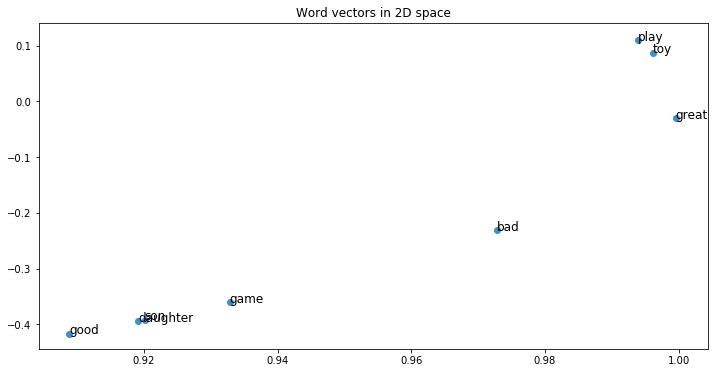

In [28]:
M_svd_2d = f.matrix_reduce(M_svd, method='svd', n_dim=2)
f.plot_vectors_2d(M_svd_2d, viz_words, word2ind)

#### Convert test string into SVD vector

In [29]:
f.avg_cooc_embeddings(review_ind_test, svd_reduced_co_occurrence, word2ind)

array([3700.67999817, -820.60835517,   62.69732848, -657.55311825,
       1061.47692555])

In [30]:
f.save_pickle(M_svd, 'data/M_svd_100k.pickle')
del M_svd

### Co-Occurrence Matrix with NMF (Non-Negative Matrix Factorization)

In [31]:
nmf_reduced_co_occurrence = f.matrix_reduce(M_co_occurrence, method='nmf', n_dim=5)
M_nmf = np.stack([f.avg_cooc_embeddings(ind, nmf_reduced_co_occurrence, word2ind) for ind in reviews_ind])
M_nmf.shape

C:\Users\klaud\Anaconda3\envs\fastai-nlp\lib\site-packages\sklearn\decomposition\_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


(100000, 5)

In [32]:
print(M_nmf)

[[ 4.73204311  3.10003703  4.33827005  4.17181511  7.71958402]
 [ 8.04826308  5.81789377  7.47526516  5.45424254 14.58321622]
 [ 8.20413043 15.00659014 19.79551483 17.25447144 30.89723242]
 ...
 [10.16579462  8.22098302 10.5652474   1.76599422 19.62267803]
 [14.19922071  0.56729811  0.62328625  3.7909095   1.45206812]
 [ 2.90358797  0.75351253  1.38886852 10.85750284  7.32522433]]


#### NMF word embeddings in vector space

Based on the selected list of words, NMF word embeddings seem to perform similarly to SVD word vectors.

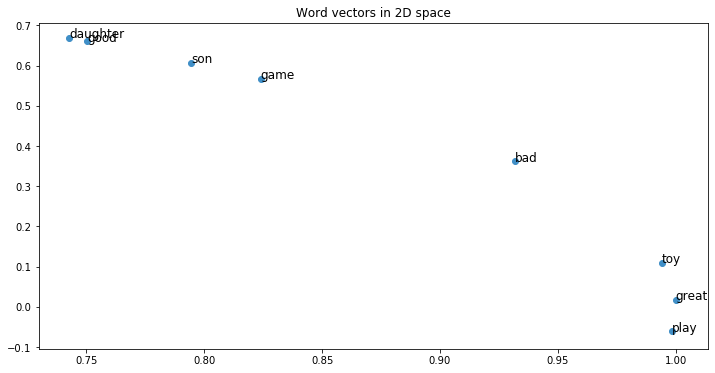

In [33]:
M_nmf_2d = f.matrix_reduce(M_nmf, method='svd', n_dim=2)
f.plot_vectors_2d(M_nmf_2d, viz_words, word2ind)

#### Convert test string into NMF vector

In [34]:
f.avg_cooc_embeddings(review_ind_test, nmf_reduced_co_occurrence, word2ind)

array([ 3.39747279,  1.78241199,  3.35470569, 32.29559881, 21.61569199])

In [35]:
f.save_pickle(M_nmf, 'data/M_nmf_100k.pickle')
del M_nmf

## Word2Vec

Word2Vec is a two-layer neural network used to learn word associations from a large corpus of text. Its output are word embeddings that represent words from text corpus. Word2Vec model represents words in dense low dimensional space in a way that similar words get similar word vectors, so they are mapped to nearby points.

In [36]:
bigram_transformer = Phrases(common_texts)
w2v_model = Word2Vec(min_count=5,
                     window=3,
                     size=100,
                     workers=3)

In [37]:
w2v_model.build_vocab(reviews_tokens)
w2v_model.train(reviews_tokens, total_examples=w2v_model.corpus_count, epochs=30)

(42810830, 50905110)

In [38]:
M_word2vec = np.stack([f.avg_w2v_embeddings(review, w2v_model) for review in reviews_tokens])
M_word2vec.shape

(100000, 100)

#### Word2Vec word embeddings in vector space

Word2Vec word embeddings reflect the true relations between words, eg: "good" and "great" are the synonymes, close to the "bad" word (it's the adjective describing the same feature) but there is distance between them (since "bad" is the opposite word). "Game", "toy" and "play" are located in close neighbourhood in vector space, the same as "son" and "daughter".

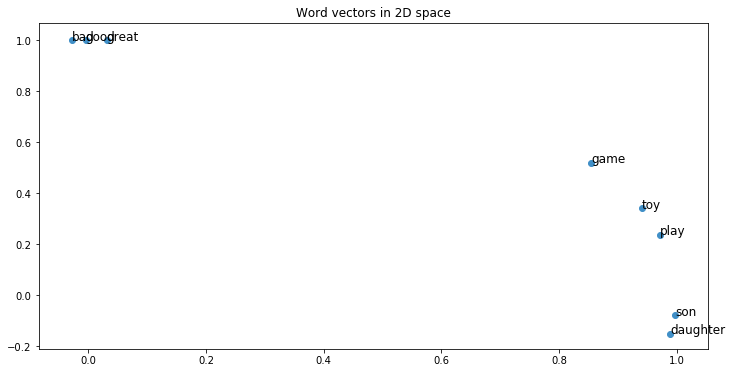

In [39]:
M_w2v_words = w2v_model.wv[viz_words]
M_w2v_words_2d = f.matrix_reduce(M_w2v_words, 'svd', n_dim=2)
w2v_word2ind = {e:i for i, e in enumerate(viz_words)}
f.plot_vectors_2d(M_w2v_words_2d, viz_words, w2v_word2ind)

#### Convert test string into Word2Vec vector


In [40]:
f.avg_w2v_embeddings(review_tokens_test, w2v_model)

array([-0.31646168, -0.56161016,  1.0844812 , -0.18825021,  1.3932753 ,
        0.14343838,  1.0295175 ,  0.9405424 , -0.41131052, -0.04139958,
       -0.13122456, -0.2395148 ,  0.12359241, -0.17586541,  0.2841231 ,
       -0.662642  , -0.4899149 , -0.82126445, -0.4849453 , -0.01437436,
        0.5155698 ,  0.00157979, -0.12170897,  0.12294563, -0.56744236,
        0.09137762,  0.13993731, -0.50038534, -0.6875189 ,  0.20462283,
       -0.2606817 , -0.20736933, -0.14295428,  0.79791254, -0.55176574,
        0.64750224, -0.573746  ,  0.03562661, -0.3149734 , -0.36117828,
       -0.5166572 ,  1.468988  ,  0.35668358, -0.93026483,  0.07668543,
        0.16054472, -0.542458  , -0.80053425,  0.49514374, -0.70084465,
       -0.85109246,  0.36010742,  0.28695327, -0.6446176 , -0.26563647,
       -0.32876414,  0.233358  ,  0.03792597, -1.2165335 , -0.46383953,
       -0.761924  , -1.0288746 , -0.37649328, -0.4844675 ,  1.208699  ,
       -0.18409283,  0.23793969,  0.4282012 ,  0.42860514, -0.00

In [41]:
f.save_pickle(M_word2vec, 'data/M_word2vec_100k.pickle')
del M_word2vec